# Adiabatic SSM model

This notebook takes multiple local SSM models which have been identified at pre-tensioned equilibria and interpolates them to obtain one adiabatic SSM model. The model performance is evaluated by its ability to predict open-loop trajectories.

In [1]:
from os import listdir
from os.path import join
import pickle
import yaml
import numpy as np
np.set_printoptions(linewidth=100)

In [2]:
%load_ext autoreload
%autoreload 2
import utils as utils
import plot_utils as plot

## Import local SSM models

In [3]:
# directory containing the SSM models
model_dir = "/media/jonas/Backup Plus/jonas_soft_robot_data/trunk_adiabatic"
model_names = sorted(listdir(model_dir))
model_names

['east', 'north', 'origin', 'south', 'west']

Load the pre-tensioned equilibrium of each model and plot adiabatic SSM map

In [4]:
q_eq, u_eq = [], []
for model in model_names:
    with open(join(model_dir, model, "SSMmodel", "pre-tensioned_rest_q.pkl"), "rb") as f:
        q_eq.append(pickle.load(f))
    with open(join(model_dir, model, "decay", "info.yaml"), "r") as f:
        info = yaml.safe_load(f)
    u_eq.append(np.array(info['pre_tensioning']))
print(q_eq)
print(u_eq)

[array([34.95441827, -0.27574755, -7.94720868]), array([ 0.54467017, 35.57246381, -6.34727727]), array([ 0.03909428, -0.08913968, -0.00175868]), array([  0.27917007, -35.77321019,  -6.25407621]), array([-35.30795769,  -0.42439489,  -4.08499071])]
[array([  0,   0,   0, 200,   0,   0,   0, 200]), array([200,   0,   0,   0, 200,   0,   0,   0]), array([0, 0, 0, 0, 0, 0, 0, 0]), array([  0,   0, 200,   0,   0,   0, 200,   0]), array([  0, 200,   0,   0,   0, 200,   0,   0])]


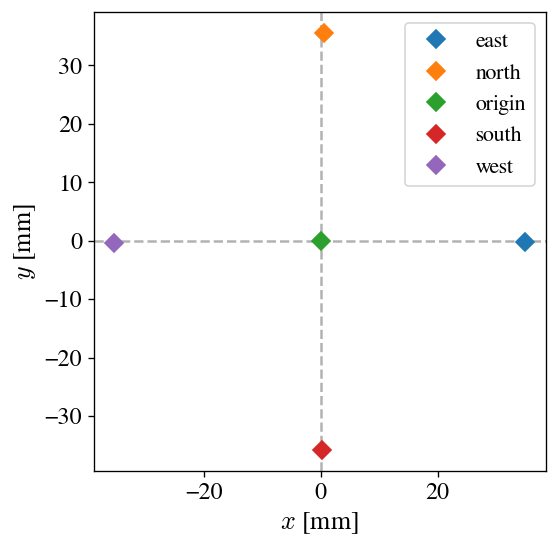

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi=120)

for i, model in enumerate(model_names):
    ax.plot(q_eq[i][0], q_eq[i][1], marker="D", markersize=8, ls="", label=model)
ax.axhline(0, ls='--', color='grey', zorder=1, alpha=.6)
ax.axvline(0, ls='--', color='grey', zorder=1, alpha=.6)
ax.set_xlabel(r"$x$ [mm]")
ax.set_ylabel(r"$y$ [mm]")
ax.set_aspect("equal")
ax.legend()
plt.show()

## Model weighting

### 1. Distance weighting

In [50]:
DECAY_EXP = 2

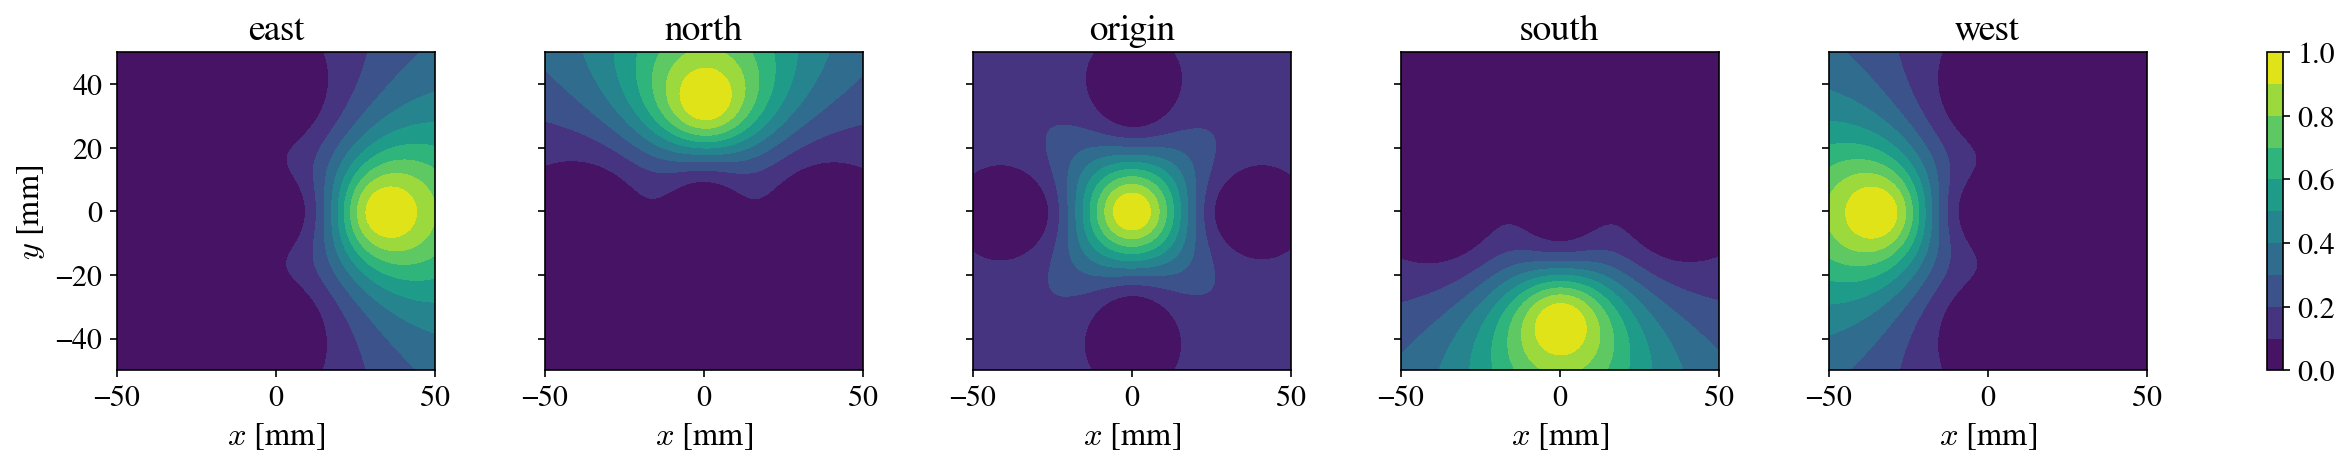

In [51]:
import matplotlib as mpl

nx, ny = (100, 100)
grid_lims = (-50, 50)
x = np.linspace(grid_lims[0], grid_lims[1], nx)
y = np.linspace(grid_lims[0], grid_lims[1], ny)
xv, yv = np.meshgrid(x, y, sparse=False)

model_weights = []
colormaps = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']

xy_rest = np.array([q_eq[i][:2] for i in range(len(model_names))])
model_weights = 1 / np.linalg.norm(np.stack([xy_rest[i, :] - np.stack((xv, yv), axis=-1) for i in range(len(model_names))]), axis=-1) ** DECAY_EXP
model_weights /= np.sum(model_weights, axis=0)

fig, axs = plt.subplots(1, len(model_names), figsize=(16, 3), dpi=150, sharey=True, constrained_layout=True)
im = None
for i, model in enumerate(model_names):
    ax = axs[i]
    im = ax.contourf(x, y, model_weights[i, :, :],
                    vmin=0, vmax=1, levels=10) # cmap=mpl.colormaps[colormaps[i]])
    ax.set_title(model)
    ax.set_xlabel(r"$x$ [mm]")
    ax.set_aspect("equal")
axs[0].set_ylabel(r"$y$ [mm]")
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

In [7]:
xy_rest = np.array([q_eq[i][:2] for i in range(len(model_names))])
# print(xy_rest)
def interpolate_coeffs(xy, coeffs: list):
    print(xy.ndim)
    if xy.ndim > 1:
        weights = np.stack([np.exp(-np.linalg.norm(xy_rest - xy[:, i], axis=1)/decay_rate) for i in range(xy.shape[1])]).T
        # print(weights)
        weights /= np.sum(weights, axis=0)
        return np.tensordot(weights.T, np.stack(coeffs), axes=1)
    else:
        # weights = np.exp(-np.linalg.norm(xy_rest - xy, axis=1) * decay_rate)
        weights = 1 / np.linalg.norm(xy_rest - xy, axis=1) ** 100
        # print(weights.shape)
        # assert len(weights) == len(coeffs)
        # print(np.linalg.norm(xy_rest - xy, axis=1))
        # print(weights)
        weights /= np.sum(weights)
        return np.sum([coeffs[i] * weights[i] for i in range(len(coeffs))], axis=0), weights
    # return coeffs[2] # use only model from origin

coeffs = [np.random.random((7, 12)) for i in range(5)]
print(interpolate_coeffs(np.zeros((2, 4)), coeffs).shape)

(7, 12)


Define mappings of adiabatic SSM

In [8]:
models = []
for model_name in model_names:
    with open(join(model_dir, model_name, "SSMmodel", "SSM_model.pkl"), "rb") as f:
        model = pickle.load(f)
        models.append(model)
Vde = [model['model']['V'] for model in models]
r_coeff = [model['model']['r_coeff'] for model in models]
w_coeff = [model['model']['w_coeff'] for model in models]
print(w_coeff[0].shape)
B = [model['model']['B'] for model in models]
ROMOrder = [model['params']['ROM_order'] for model in models]
SSMOrder = [model['params']['SSM_order'] for model in models]

(15, 83)


In [9]:
print(w_coeff[0].shape)

(15, 83)


## Evaluate model performance

In [10]:
observables = "delay-embedding" # "pos-vel" # 
N_DELAY = 4 # only relevant if observables is "delay-embedding"
TIP_NODE = 51
N_NODES = 709
INPUT_DIM = 8
DT = 0.01

rDOF = 3
oDOF = 3
SSMDim = 6

robot_dir = "../../../soft-robot-control/examples/trunk"
data_dir = "/media/jonas/Backup Plus/jonas_soft_robot_data/trunk_adiabatic/origin"
rest_file = join(robot_dir, 'rest_qv.pkl')

### Prediction of autonomous dynamics

Test autonomous reduced dynamics of adiabatic SSM on decay trajectories around origin

In [11]:
t_in = 1
t_out = 4

decayData_dir =  join(data_dir, "decay")
Data = {}
Data['oData'] = utils.import_pos_data(decayData_dir, rest_file=rest_file, output_node=TIP_NODE, t_in=t_in, t_out=t_out)

nTRAJ = len(Data['oData'])
print("nTRAJ:", nTRAJ)

nTRAJ: 40


Compute observables (delay embedding)

In [12]:
from copy import deepcopy

N_DELAY = 4

assemble_observables = lambda oData: utils.delayEmbedding(oData, up_to_delay=N_DELAY)
Data['yData'] = deepcopy(Data['oData'])
for i in range(nTRAJ):
    Data['yData'][i][1] = assemble_observables(Data['oData'][i][1])

Plot tip position

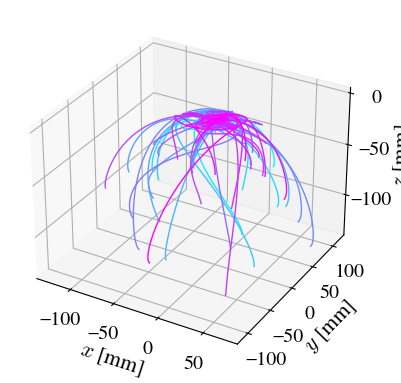

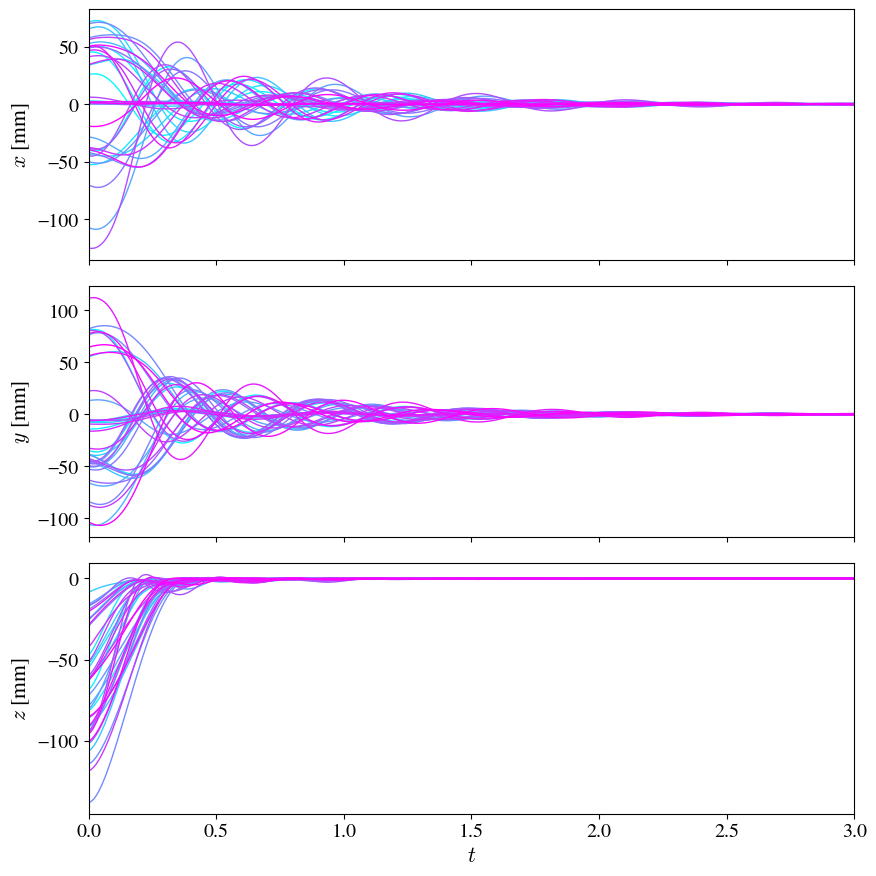

In [13]:
outdofs = [0, 1, 2]

plt.close('all')
# plot trajectories in 3D [x, y, z] space
plot.traj_3D(Data,
             xyz_idx=[('yData', outdofs[0]), ('yData', outdofs[1]), ('yData', outdofs[2])],
             xyz_names=[r'$x$ [mm]', r'$y$ [mm]', r'$z$ [mm]'])
# plot evolution of x, y and z in time, separately in 3 subplots
plot.traj_xyz(Data,
             xyz_idx=[('yData', outdofs[0]), ('yData', outdofs[1]), ('yData', outdofs[2])],
             xyz_names=[r'$x$ [mm]', r'$y$ [mm]', r'$z$ [mm]'])

Slice trajectories to facilitate open-loop prediction

In [14]:
t_interval = [0.1, 3]
Data['oDataTrunc'] = utils.slice_trajectories(Data['oData'], t_interval)
Data['yDataTrunc'] = utils.slice_trajectories(Data['yData'], t_interval)

Integrate autonomous dynamics using forward Euler / does not make sense to use non-origin models to do so... No notion of inputs / pre-tensioning!

In [15]:
def advect_adiabaticRD(yData):
    etaRec, yRec = deepcopy(yData), deepcopy(yData)
    for j in range(len(yData)):
        dt = 0.01
        N = int((t_interval[1] - t_interval[0]) / dt)
        y0 = yData[j][1][:, 0]
        # print("y0:", y0)
        x = np.zeros((6, N+1))
        y = np.zeros((15, N+1))
        y[:, 0] = y0
        for i in range(N):
            x[:, i] = interpolate_coeffs(y[:2, i], Vde).T @ (y[:, i].T - np.tile(interpolate_coeffs(y[:2, i], q_eq), 5))
            xdot = interpolate_coeffs(y[:2, i], r_coeff) @ utils.multivariate_polynomial(x[:, i].reshape(-1, 1), ROMOrder[0])
            x[:, i+1] = x[:, i] + dt * xdot.flatten()
            y[:, i+1] = (interpolate_coeffs(y[:2, i], w_coeff) @ utils.multivariate_polynomial(x[:, i+1].reshape(-1, 1), SSMOrder[0])).T + np.tile(interpolate_coeffs(y[:2, i], q_eq), 5)
        etaRec[j][1] = x
        yRec[j][1] = y
    return etaRec, yRec

In [16]:
# reduced dynamics error
trajRec = {}
trajRec['x'], trajRec['y'] = advect_adiabaticRD(Data['yDataTrunc'][:10])

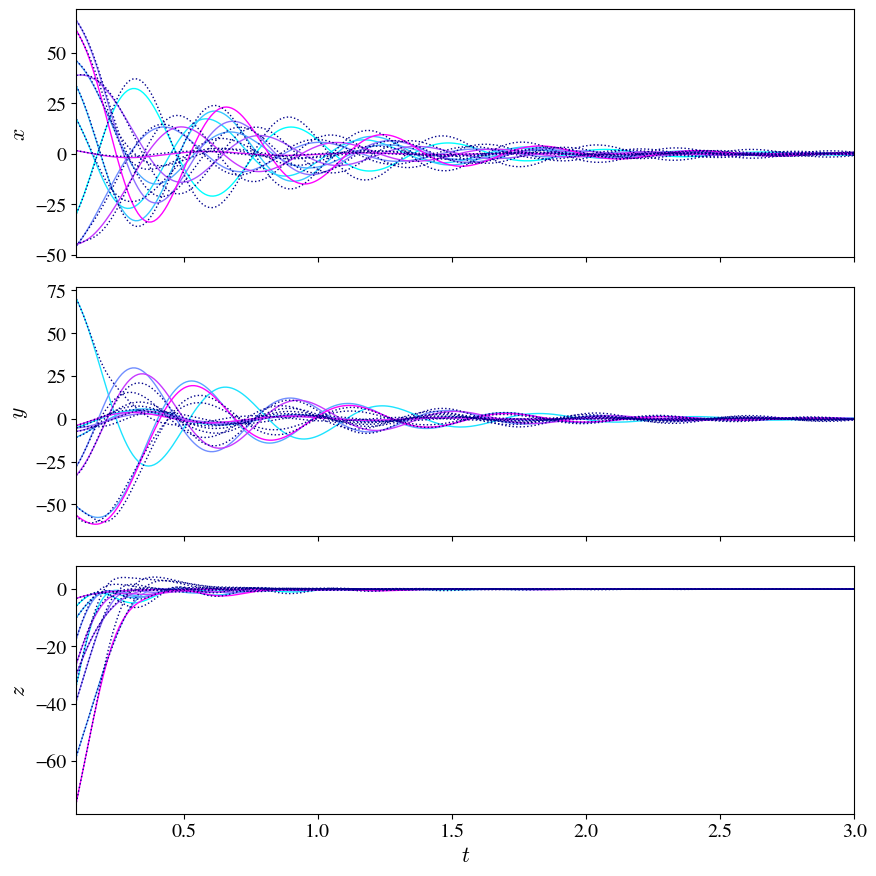

In [17]:
axs = plot.traj_xyz(Data,
                    xyz_idx=[('yDataTrunc', 0), ('yDataTrunc', 1), ('yDataTrunc', 2)],
                    xyz_names=[r'$x$', r'$y$', r'$z$'],
                    traj_idx=list(range(10)),
                    show=False)
plot.traj_xyz(trajRec,
            xyz_idx=[('y', 0), ('y', 1), ('y', 2)],
            xyz_names=[r'$x$', r'$y$', r'$z$'],
            traj_idx=None,
            axs=axs, ls=':', color='darkblue')

### Prediction of open-loop trajectories

Predict open-loop trajectories using the interpolated adiabatic SSM model

In [18]:
test_results = {}
test_trajectory_folders = ['open-loop_circle']
test_trajectories = []
for test_traj in test_trajectory_folders:
    traj_dir = join(robot_dir, "dataCollection", test_traj)
    (t, z), u = utils.import_pos_data(data_dir=traj_dir,
                                      rest_file=rest_file,
                                      output_node=TIP_NODE, return_inputs=True, traj_index=0)
    # z = (z.T - q_eq).T
    # u = (u.T - u_eq).T
    y = assemble_observables(z)
    print("y.shape:", y.shape)
    print("u.shape:", u.shape)

    test_trajectories.append({
            'name': test_traj,
            't': t,
            'z': z,
            'u': u,
            'y': y
        })

y.shape: (15, 1002)
u.shape: (8, 1002)


In [19]:
def advect_adiabaticRD_with_inputs(t, y0, u, y):
    dt = 0.01
    N = len(t)-1
    x = np.zeros((6, N+1))
    y_pred = np.zeros((15, N+1))
    # y = y_pred
    y_bar = np.zeros((15, N+1))
    u_bar = np.zeros((8, N+1))
    xdot = np.zeros((6, N+1))
    y_pred[:, 0] = y0
    weights = np.zeros((5, N+1))
    for i in range(N):
        weights[:, i] = interpolate_coeffs(y[:2, i], [1])[1]
        y_bar[:, i] = np.tile(interpolate_coeffs(y[:2, i], q_eq)[0], 5)
        u_bar[:, i] = interpolate_coeffs(y[:2, i], u_eq)[0]
        # print(y[:2, i])
        x[:, i] = interpolate_coeffs(y[:2, i], Vde)[0].T @ (y_pred[:, i].T - y_bar[:, i])
        # print("B @ u.shape:", (interpolate_coeffs(y[:2, i], B) @ u[:, i]).shape)
        xdot[:, i] = (interpolate_coeffs(y[:2, i], r_coeff)[0] @ utils.multivariate_polynomial(x[:, i].reshape(-1, 1), ROMOrder[0])).flatten() + interpolate_coeffs(y[:2, i], B)[0] @ (u[:, i] - u_bar[:, i])
        x[:, i+1] = x[:, i] + dt * xdot[:, i]
        y_pred[:, i+1] = (interpolate_coeffs(y[:2, i], w_coeff)[0] @ utils.multivariate_polynomial(x[:, i+1].reshape(-1, 1), SSMOrder[0])).T + y_bar[:, i]
    return x, y_pred, xdot, y_bar, u_bar, weights

In [20]:
traj = test_trajectories[0]
print(traj['name'])
x, y, xdot, y_bar, u_bar, weights = advect_adiabaticRD_with_inputs(traj['t'], traj['y'][:, 0], traj['u'], traj['y'])

open-loop_circle


IndexError: list index out of range

In [ ]:
# Trajectory z (predicted vs. actual)
axs = plot.traj_xyz_txyz(traj['t'],
                            y[0, :], y[1, :], y[2, :],
                            show=False)
axs = plot.traj_xyz_txyz(traj['t'],
                        traj['z'][0, :], traj['z'][1, :], traj['z'][2, :],
                        color="tab:orange", axs=axs, show=False)
axs[-1].legend(["Predicted trajectory", "Actual trajectory"])
plt.suptitle(r"Trajectory $z$ (predicted vs. actual)")
plt.show()

# xdot
axs = plot.traj_xyz_txyz(traj['t'],
                            xdot[0, :], xdot[1, :], xdot[2, :],
                            xyz_names=[r"$\dot{x_1}$", r"$\dot{x_2}$", r"$\dot{x_3}$"],
                            show=False)
plt.suptitle(r"$\dot{x}$")
plt.show()

# y_bar
axs = plot.traj_xyz_txyz(traj['t'],
                            y_bar[0, :], y_bar[1, :], y_bar[2, :],
                            xyz_names=[r"$\bar{y_1}$", r"$\bar{y_2}$", r"$\bar{y_3}$"],
                            show=False)
plt.suptitle(r"$\bar{y}}$")
plt.show()

# u_bar
axs = plot.traj_xyz_txyz(traj['t'],
                            u_bar[0, :], u_bar[1, :], u_bar[2, :],
                            xyz_names=[r"$\bar{u_1}$", r"$\bar{u_2}$", r"$\bar{u_3}$"],
                            show=False)
plt.suptitle(r"$\bar{u}}$")
plt.show()

# weights
axs = plot.traj_xyz_txyz(traj['t'],
                        weights[:, :].T, np.tile(np.nan, len(traj['t'])), np.tile(np.nan, len(traj['t'])),
                        xyz_names=[r"weights", r"", r""],
                        show=False)
plt.suptitle(r"weights")
plt.show()

In [ ]:
# autonomous
def Wauton(y):
    # print(np.tile(interpolate_coeffs(y[:2], q_eq), 5).shape)
    print("interpolated Vde.shape:", interpolate_coeffs(y[:2], Vde).shape)
    # print((y.T - np.tile(interpolate_coeffs(y[:2], q_eq), 5)).shape)
    print("y.shape:", y.shape)
    if y.ndim > 1:
        return np.stack([interpolate_coeffs(y[:2], Vde)[i, :, :].T @ (y.T - np.tile(interpolate_coeffs(y[:2], q_eq), 5))[i, :] for i in range(y.shape[1])], axis=-1)
    else:
        return interpolate_coeffs(y[:2], Vde).T @ (y.T - np.tile(interpolate_coeffs(y[:2], q_eq), 5))
    # return np.tensordot(interpolate_coeffs(y[:2], Vde), y.T - np.tile(interpolate_coeffs(y[:2], q_eq), 5), axes=[(1), (1)])
# with control
assemble_features = lambda u, x: utils.multivariate_polynomial(u, order=1)

In [ ]:
test_results = {}
test_trajectory_folders = ['open-loop_circle']
test_trajectories = []
for test_traj in test_trajectory_folders:
    traj_dir = join(robot_dir, "dataCollection", test_traj)
    (t, z), u = utils.import_pos_data(data_dir=traj_dir,
                                      rest_file=rest_file,
                                      output_node=TIP_NODE, return_inputs=True, traj_index=0, t_out=1)
    # z = (z.T - q_eq).T
    # u = (u.T - u_eq).T
    y = assemble_observables(z)
    x = Wauton(y)

    x0 = x[:, 0]
    y0 = y[:, 0]
    assert np.allclose(x0, Wauton(y0))
    print("x0:", x0)
    print(interpolate_coeffs(y0[:2], w_coeff).shape)
    print(utils.multivariate_polynomial(x, SSMOrder[0]).shape)
    def W0(x):
        shift = np.tile(interpolate_coeffs(y0[:2], q_eq), 5)
        print("w_coeff_interp.shape:", interpolate_coeffs(y0[:2], w_coeff).shape)
        print("x_features.shape:", utils.multivariate_polynomial(x, SSMOrder[0]).shape)
        return (interpolate_coeffs(y0[:2], w_coeff) @ utils.multivariate_polynomial(x, SSMOrder[0])).T + shift
    y0_pred = W0(np.atleast_2d(x0).T)
    print("y0:", y0)
    print("W0(x0):", y0_pred)

    global W
    W = W0

    def Vauton(x):
        global W
        print("x.shape:", x.shape)
        y = W(x).T
        print("(Vauton) y.shape:", y.shape)
        W = lambda x: (interpolate_coeffs(y[:2], w_coeff) @ utils.multivariate_polynomial(x, SSMOrder[0])).T + np.tile(interpolate_coeffs(y[:2], q_eq), 5)
        return y
    
    def Rauton(x):
        print("r_coeff_interp.shape:", interpolate_coeffs(Vauton(x)[:2], r_coeff).shape)
        print("x_features.shape:", utils.multivariate_polynomial(x, ROMOrder[0]).shape)
        return interpolate_coeffs(Vauton(x)[:2], r_coeff) @ utils.multivariate_polynomial(x, ROMOrder[0])

    def R(x, u):
        print("evaluate R")
        print(x.shape)
        print(u.shape)
        a = Rauton(x.T)
        print("here 1")
        b = interpolate_coeffs(Vauton(x)[:2], B)
        print("here 2")
        c = assemble_features(u - interpolate_coeffs(Vauton(x)[:2], u_eq), x)
        return a + b @ c

    print(y.shape)
    print(x.shape)

    test_trajectories.append({
            'name': test_traj,
            't': t,
            'z': z,
            'u': u,
            'x': x
        })

In [ ]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def predict_open_loop(R, Vauton, t, u, x0, method='RK45'):

    print(x0)
    print(t.shape)
    print(u.shape)

    uInterpFun = interp1d(t, u, axis=1, fill_value="extrapolate")
    uFun = lambda t: uInterpFun(t).reshape(-1, 1)
    R_t = lambda t, x: R(np.atleast_2d(x).T, uFun(t))
    # solve IVP of reduced dynamics using open-loop inputs
    sol = solve_ivp(R_t,
                    t_span=[t[0], t[-1]],
                    t_eval=t,
                    y0=x0,
                    method=method,
                    vectorized=True,
                    rtol=1e-3,
                    atol=1e-3)
    # resulting (predicted) open-loop trajectory in reduced coordinates
    xTraj = sol.y
    yTraj = Vauton(xTraj)
    zTraj = yTraj[:3, :]
    # if integration unsuccessful, fill up solution with nans
    if zTraj.shape[1] < len(t):
        zTraj = np.hstack((zTraj, np.tile(np.nan, (3, len(t) - zTraj.shape[1]))))
    return zTraj

In [ ]:
PLOTS = 'show'
for traj in test_trajectories:
    z_pred = predict_open_loop(R, Vauton, traj['t'], traj['u'], x0=traj['x'][:, 0])
    rmse = float(np.sum(np.sqrt(np.mean((z_pred[:3, :] - traj['z'][:3])**2, axis=0))) / len(traj['t']))
    print(f"({traj['name']}): RMSE = {rmse:.4f}")
    test_results[traj['name']] = {
        'RMSE': rmse
    }
    if PLOTS:
        axs = plot.traj_xyz_txyz(traj['t'],
                                z_pred[0, :], z_pred[1, :], z_pred[2, :],
                                show=False)
        axs = plot.traj_xyz_txyz(traj['t'],
                                traj['z'][0, :], traj['z'][1, :], traj['z'][2, :],
                                color="tab:orange", axs=axs, show=(PLOTS == 'show'))
        axs[-1].legend(["Predicted trajectory", "Actual trajectory"])
print(f"(overall): RMSE = {np.mean([test_results[traj]['RMSE'] for traj in test_results]):.4f}")